In [11]:
import numpy as np
from scipy.io import loadmat
from scipy import stats, signal

import matplotlib.pyplot as plt

import os
import sys

from sklearn.decomposition import PCA, SparsePCA, FastICA, NMF
from sklearn.manifold import Isomap

from pathlib import Path
with open("../default_paths.txt", 'r') as file:
    lines = file.readlines()
    data_path    = Path(lines[0].strip().split("=")[1])
    project_path = Path(lines[1].strip().split("=")[1])
    
utils_path = project_path / "utils"
sys.path.insert(0, str(utils_path))

from data_utils import process_file, process_all_files

train_path   = data_path / "train"
test_path    = data_path / "test"
holdout_path = data_path / "competitionHoldOut"

fnames_train = os.listdir(train_path)
fnames_test = os.listdir(test_path)
fnames_holdout = os.listdir(holdout_path)

In [1]:
import numpy as np

In [2]:
np.random.randint(0, 10)

6

In [3]:
max_samples = 3000
n_samples = 1000
rand_shift = 60


(rand_shift, max_samples - n_samples - rand_shift)

(60, 1940)

## PCA

In [9]:
%%time
data_res = process_all_files(train_path)

CPU times: total: 14.6 s
Wall time: 35.3 s


In [18]:
fname = fnames_train[0]

brain_list, _, _ = process_file(train_path / fname)

In [19]:
X_concat = np.concatenate(brain_list, axis=0)
X_concat.shape

(158447, 512)

In [21]:
%%time
pca = PCA().fit(X_concat)
X_pca = pca.transform(X_concat)

CPU times: total: 52.5 s
Wall time: 11.4 s


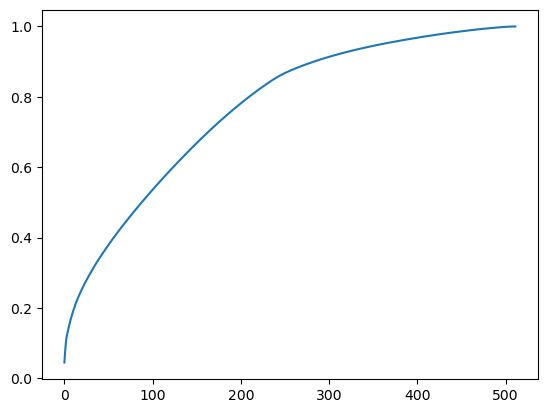

In [23]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [26]:
### ХУЙНЯ

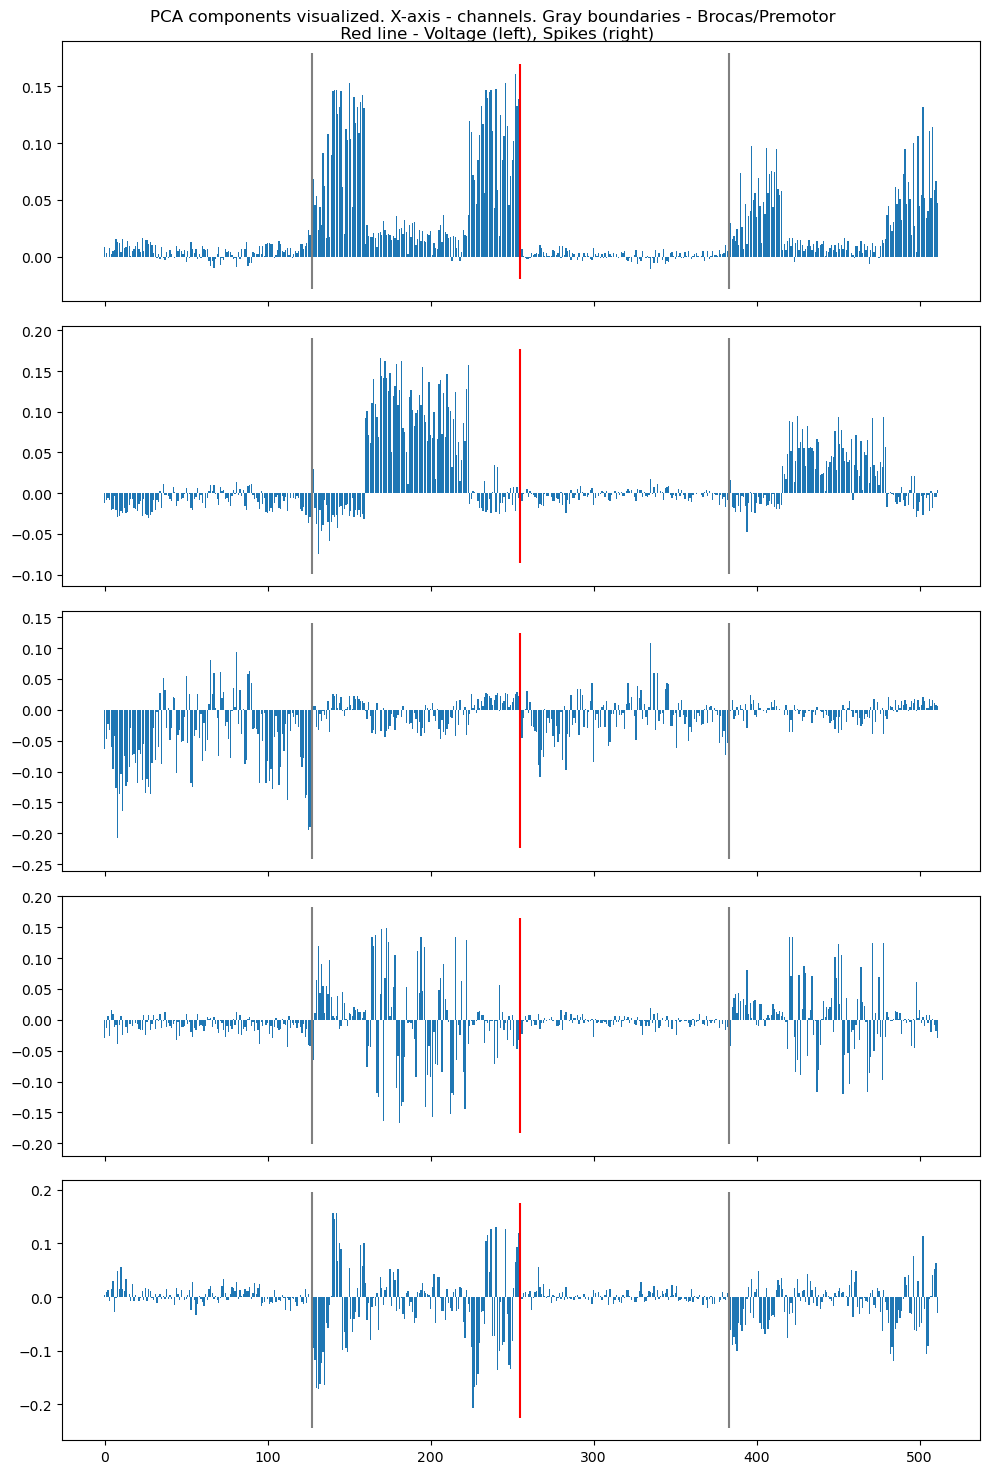

In [33]:
n_comp_show = 5
fig, axes = plt.subplots(n_comp_show, 1, sharex=True, figsize=(10, n_comp_show * 3))
plt.suptitle("PCA components visualized. X-axis - channels. Gray boundaries - Brocas/Premotor \
\n Red line - Voltage (left), Spikes (right)")

chans = np.arange(X_pca.shape[1])
for i in range(n_comp_show):
    ax = axes[i]
    ax.bar(chans, pca.components_[i])
    ax.vlines(255, *ax.get_ylim(), color='red')
    ax.vlines([127, 127 + 256], *ax.get_ylim(), color='gray')
    
plt.tight_layout()

## Isomap

In [12]:
%%time
data_res = process_all_files(test_path)

CPU times: user 1.4 s, sys: 502 ms, total: 1.9 s
Wall time: 3.46 s


In [13]:
X_concat = np.concatenate(data_res['brain_list'], axis=0, )
X_concat.shape

(264472, 256)

In [ ]:
%%time
model = Isomap(n_components=80)
model.fit(X_concat)

/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_mat

## ICA

In [14]:
%%time
data_res = process_all_files(test_path)

X_concat = np.concatenate(data_res['brain_list'], axis=0)
X = X_concat[:, :256]
X_concat.shape

CPU times: user 1.5 s, sys: 460 ms, total: 1.96 s
Wall time: 2.21 s


(264472, 256)

## PCA, ICA, NMF

In [15]:
ica = FastICA(n_components=80).fit(X)
X_emb_ica = ica.transform(X)

In [16]:
pca = PCA(n_components=80).fit(X)
X_emb_pca = pca.transform(X)

In [17]:
X_nmf = X - np.min(X)
nmf = NMF(n_components=80).fit(X_nmf)
X_emb_nmf = nmf.transform(X_nmf)\

SyntaxError: incomplete input (3039518161.py, line 3)

In [ ]:
X_emb_list = [X_emb_pca, X_emb_ica, X_emb_nmf]
label_list = ["PCA", "ICA", "NMF"]

t0 = 10000
window_size = 5000

N = len(X_emb_list)
fig, axes = plt.subplots(N + 1, 1, figsize=(10, (N + 1) * 2), sharex=True) #gridspec_kw = dict(height_ratios = [4, 1, 1, 1]))

timeslice = slice(t0, t0 + window_size)

ax = axes[0]
extent = [t0, t0 + window_size, 0, 256]
im = ax.imshow(X[timeslice, :].T, extent=extent, aspect='auto')
ax.set_ylabel("ORIG")
plt.colorbar(im, ax=ax, fraction=0.05)

extent = [t0, t0 + window_size, 0, 80]

for i in range(N):
    ax = axes[i + 1]
    im = ax.imshow(X_emb_list[i][timeslice, :].T, extent=extent, aspect='auto')
    ax.set_ylabel(label_list[i])
    plt.colorbar(im, ax=ax, fraction=0.05)


In [45]:
nmf.reconstruction_err_

3646.541375056644

In [47]:
X_pca_inv = pca.inverse_transform(X_emb_pca)
X_pca_inv.shape

(264472, 256)

In [48]:
np.linalg.norm(X - X_pca_inv)

3635.4314